In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import torch
import torchvision
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from torchvision import transforms
import torch.optim as optim

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

from skorch import NeuralNetClassifier

torch.manual_seed(2)


In [2]:
loader = DataLoader(
  torchvision.datasets.ImageFolder('../all_photo/', 
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                               [0.5,0.5,0.5],[0.5,0.5,0.5])  
                             ])),
  batch_size=1, shuffle=True)

In [3]:
test_ds, valid_ds = torch.utils.data.random_split(loader.dataset,(540, 60) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


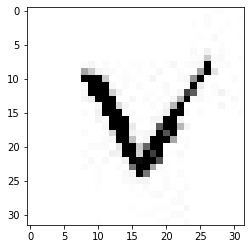

In [4]:
plt.imshow(np.transpose(loader.dataset[0][0],(1,2,0)))

In [28]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(32*32, 1)
    def forward(self, x):
        x = self.fc1(x)
        return F.sigmoid(x)
    
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #return F.log_softmax(x)
        return F.sigmoid(x)
    
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.fc1 = nn.Linear(6 * 5 * 5, 70)
        self.fc2 = nn.Linear(70, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(1, 6 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.sigmoid(x)


In [7]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [32]:
def train(epoches, net, d3=False):
    accumul_acc = []
    accumul_loss = []
    test_acc =[]
    test_loss=[]
    LEARNING_RATE = 0.0003
    
   
    loader = DataLoader(
      torchvision.datasets.ImageFolder('../all_photo/', 
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                   [0.5,0.5,0.5],[0.5,0.5,0.5])  
                                 ])), batch_size=1, shuffle=True)
    if not d3:
        loader = DataLoader(
          torchvision.datasets.ImageFolder('../all_photo/', 
                                 transform=torchvision.transforms.Compose([
                                     torchvision.transforms.Grayscale(num_output_channels=1),
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize(0.5,0.5)
                                     ])), batch_size=1, shuffle=True)
            
    test_ds, valid_ds = torch.utils.data.random_split(loader.dataset,(540, 60) )
    
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    #optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.5)
    
    for epoch in range(epoches):  # loop over the dataset multiple times
        epoch_loss = 0
        epoch_acc = 0
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(test_ds,0):
            labels = torch.Tensor([labels])
            # zero the parameter gradients
            optimizer.zero_grad()
            if not d3:
                inputs = inputs.view(1, 32*32)
            
            # forward + backward + optimize
            outputs = 0
            if d3:
                outputs = net(inputs[None, :])
            else:
                outputs = net(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            acc = binary_acc(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_loss += loss.item()
            #epoch_acc += acc.item()
            #accumul_acc.append(acc.item())
            accumul_loss.append(loss.item())
            

        
        cum_acc = 0
        cum_loss = 0
        for i, (inputs, labels) in enumerate(valid_ds,0):
            labels = torch.Tensor([labels])

            if not d3:
                inputs = inputs.view(1, 32*32)
            outputs = 0
            if d3:
                outputs = net(inputs[None, :])
            else:
                outputs = net(inputs)
            tacc = binary_acc(outputs, labels.float().unsqueeze(1))
            tloss = criterion(outputs, labels.float().unsqueeze(1))
            cum_acc += tacc.item()
            cum_loss += tloss.item()
        test_acc.append(cum_acc/len(valid_ds))
        test_loss.append(cum_loss/len(valid_ds))
    

    print('Finished Training')
    return accumul_loss, test_acc, test_loss, net

In [137]:
%%time
loss1, tacc1, tloss1, net1 = train(15,Net1())

Finished Training
CPU times: user 13.3 s, sys: 450 ms, total: 13.7 s
Wall time: 16.1 s


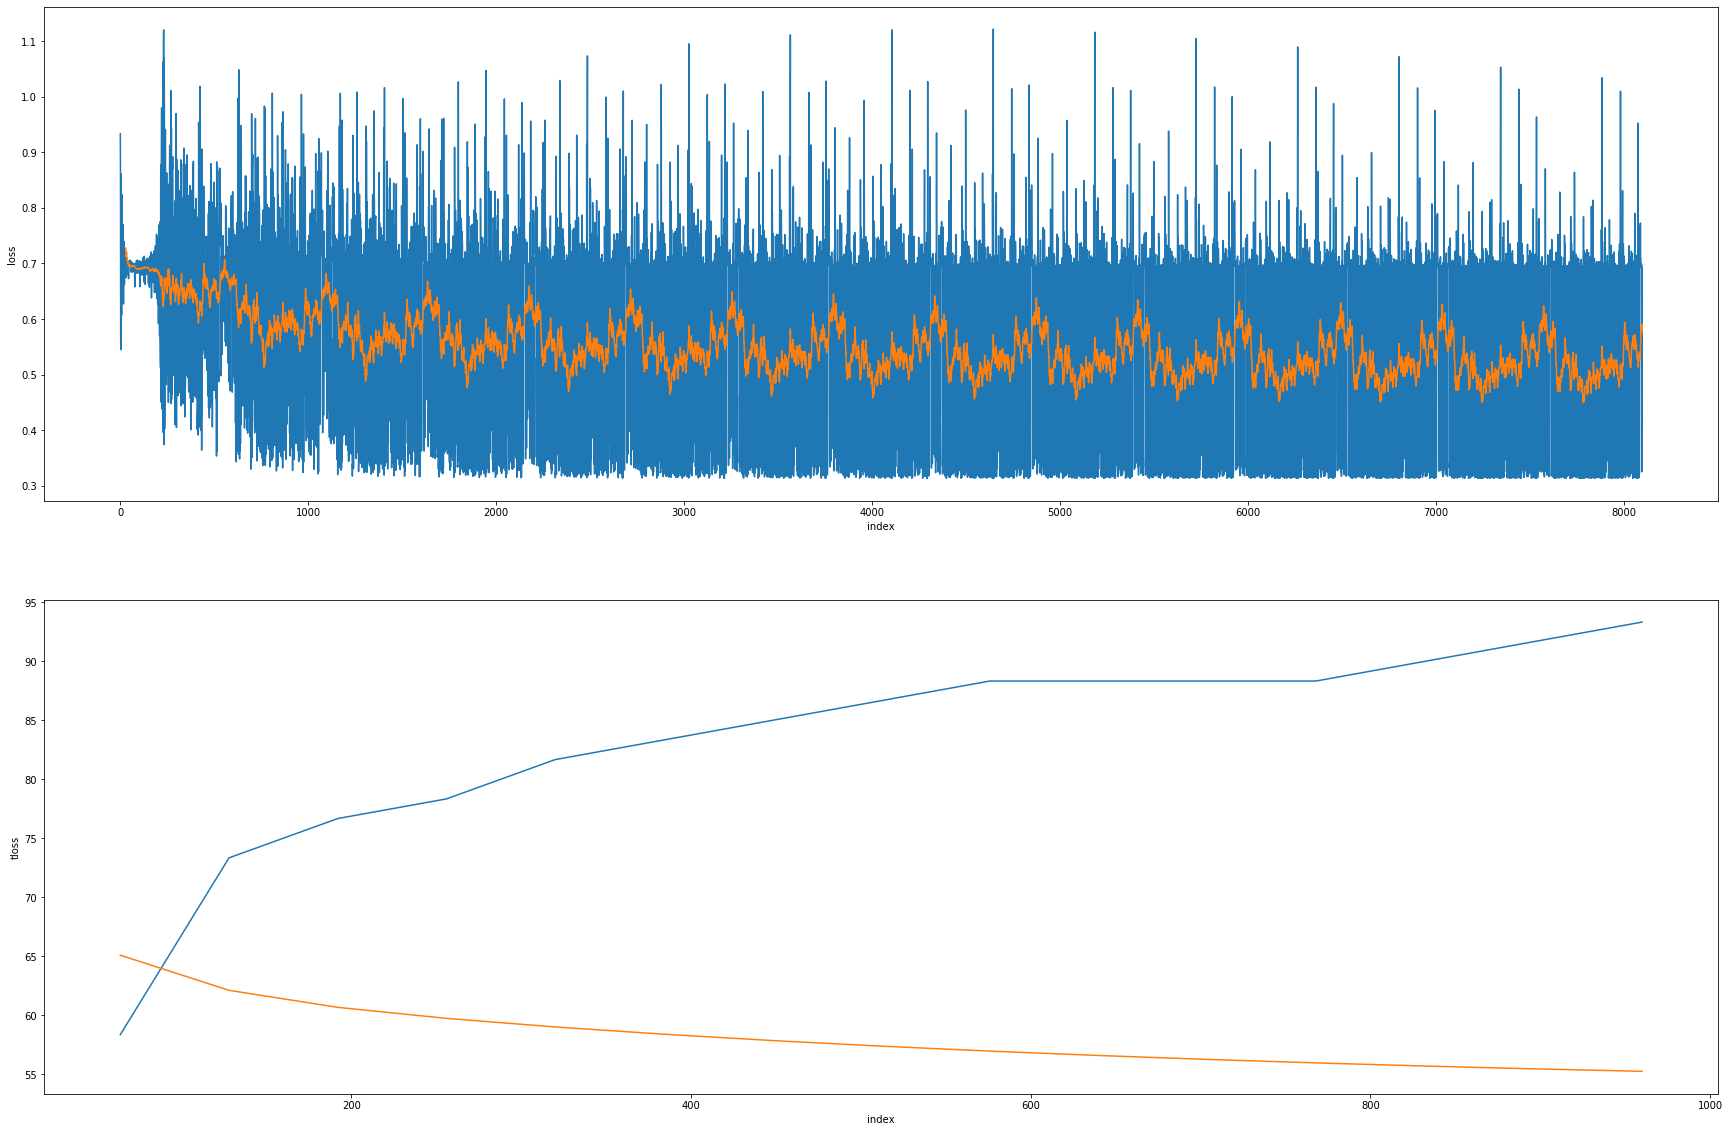

In [138]:
# train
df1 = pd.DataFrame(loss1, columns=['loss'])
df1['index'] = df1.index

# test
d1 = pd.DataFrame(tloss1, columns=['tloss'])
d1['tacc'] = tacc1
d1['index'] = (d1.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df1['index'], y=df1['loss'])
sns.lineplot(x=df1['index'], y=df1['loss'].rolling(30).mean().ffill())


# test acc and loss
plt.subplot(2,1,2)
sns.lineplot(x=d1['index'], y=d1['tacc'])
sns.lineplot(x=d1['index'], y=d1['tloss']*100)

In [123]:
%%time
loss2, tacc2, tloss2, net2 = train(15, Net2())

Finished Training
CPU times: user 23.2 s, sys: 361 ms, total: 23.5 s
Wall time: 23.5 s


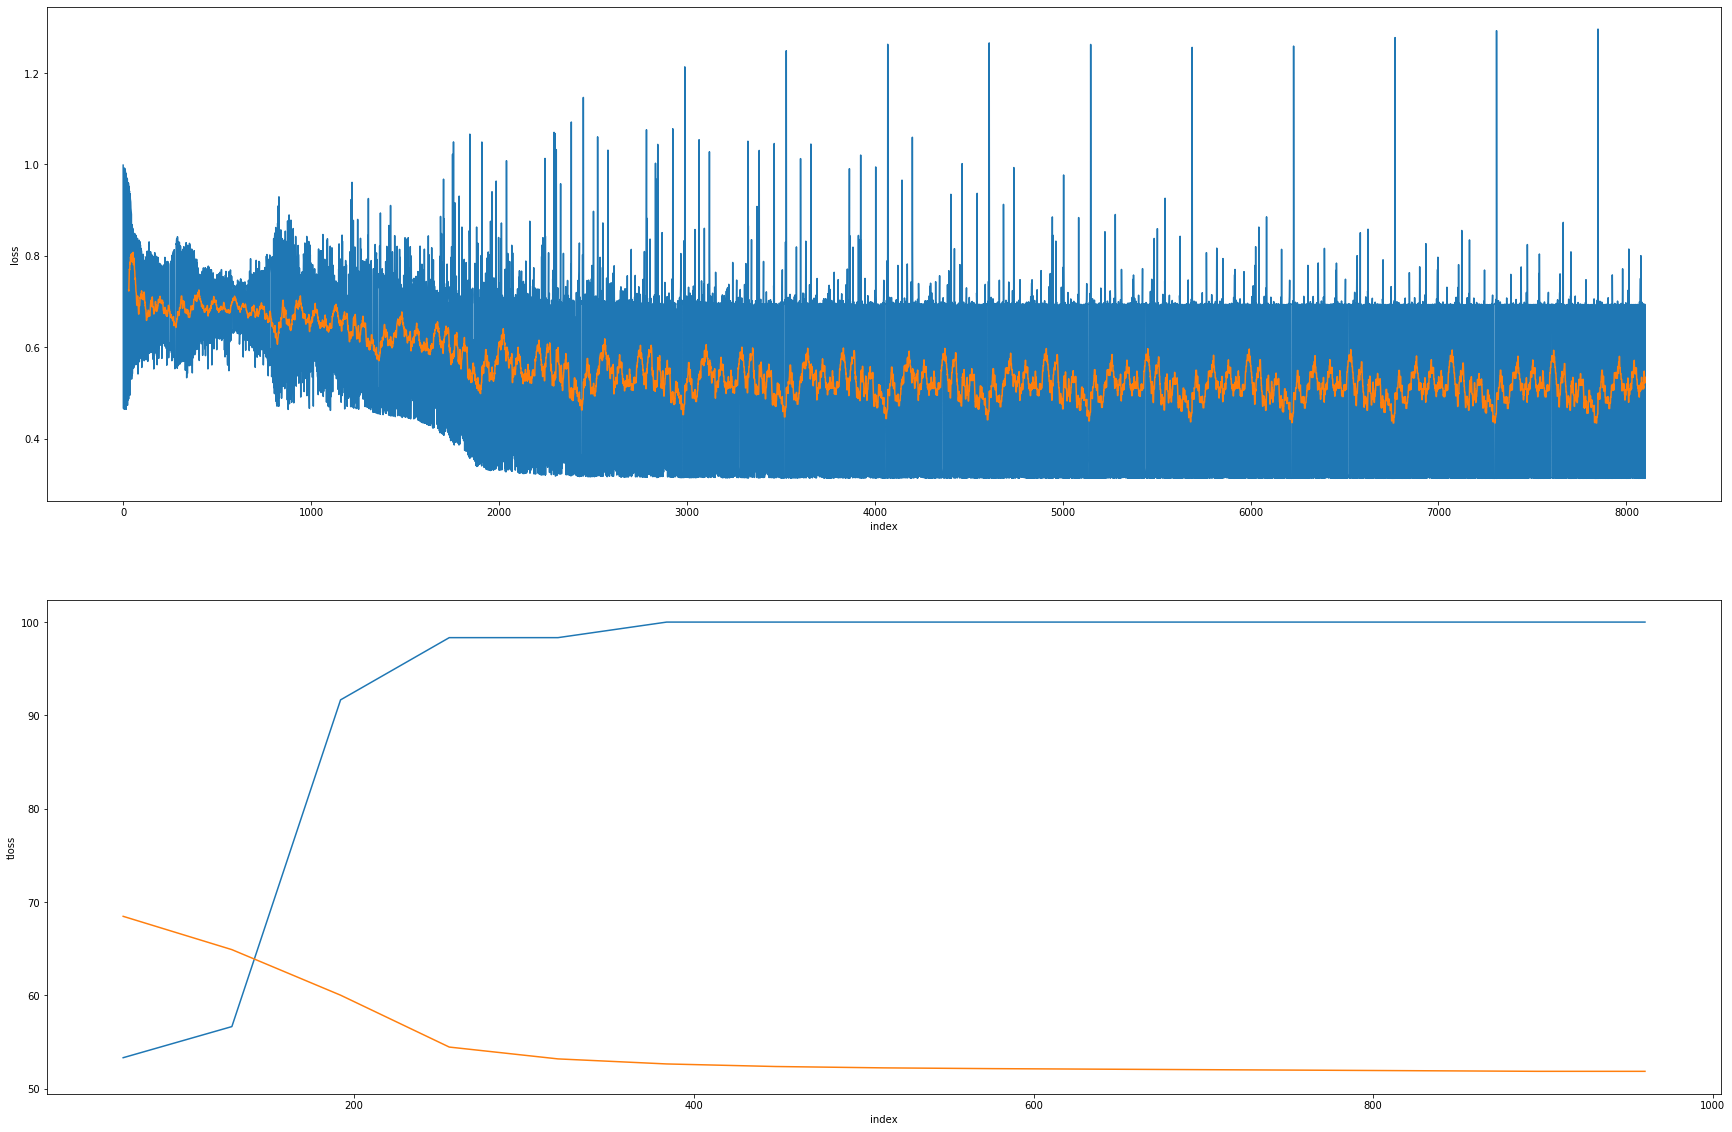

In [129]:
# train
df2 = pd.DataFrame(loss2, columns=['loss'])
df2['index'] = df2.index

# test
d2 = pd.DataFrame(tloss2, columns=['tloss'])
d2['tacc'] = tacc2
d2['index'] = (d2.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df2['index'], y=df2['loss'])
sns.lineplot(x=df2['index'], y=df2['loss'].rolling(30).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d2['index'], y=d2['tacc'])
sns.lineplot(x=d2['index'], y=d2['tloss']*100)

In [33]:
#%%debug
loss5, tacc5, tloss5, net5 = train(5, Net5(), d3=True)

Finished Training


In [34]:
# train
df5 = pd.DataFrame(loss5, columns=['loss'])
df5['index'] = df5.index

# test
d5 = pd.DataFrame(tloss5, columns=['tloss'])
d5['tacc'] = tacc5
d5['index'] = (d5.index+1)*160

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df5['index'], y=df5['loss'])
sns.lineplot(x=df5['index'], y=df5['loss'].rolling(50).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d5['index'], y=d5['tacc'])
sns.lineplot(x=d5['index'], y=d5['tloss']*100)